In [13]:
import foam_ct_phantom 
import numpy as np
from pathlib import Path
from noise2inverse import tiffs, noise,fig
import tifffile

In [20]:
# Phantom parameters
in_phantom_path = "phantom.h5"
num_voxels=512
num_slices=512
num_angles=1024
supersampling=2

# Noise
photon_count=10         # 
attenuation_factor=2.76 # corresponds to absorption of 50%

# Paths
out_proj_path = "projections_clean/proj.h5"
out_proj_dir = Path(out_proj_path).parent
out_proj_dir.mkdir(exist_ok=True)

out_proj_noisy_dir = Path("projections_noisy")
out_proj_noisy_dir.mkdir(exist_ok=True)

In [21]:
# Read in phantom sphere locations:
phantom = foam_ct_phantom.FoamPhantom(str(in_phantom_path))

# Define projection geometry
pg = foam_ct_phantom.ParallelGeometry(
    nx=num_voxels * 3 // 2,
    ny=num_slices,
    angles=np.linspace(0, np.pi, num_angles, False),
    pixsize=2 / num_voxels,
    supersampling=supersampling,
)

# Save/generate projections
if not Path(out_proj_path).exists():
    print("Generating projections")
    phantom.generate_projections(str(out_proj_path), pg)
proj = foam_ct_phantom.load_projections(str(out_proj_path))

print("Saving tiff stack of projections")
tiffs.save_stack(out_proj_dir, proj)


0it [00:00, ?it/s]

Saving tiff stack of projections


1024it [00:03, 307.23it/s]


In [22]:
# Add noise

proj *= attenuation_factor
print(f"Absorption: {noise.absorption(proj)*100:0.0f}%")
print(f"Shape:      {proj.shape}")
proj_noisy = noise.apply_noise(proj, photon_count)
proj_noisy /= attenuation_factor
proj_noisy = proj_noisy.astype(np.float32)

Absorption: 50%
Shape:      (1024, 512, 768)


In [23]:
# Save noisy projections
tiffs.save_stack(out_proj_noisy_dir, proj_noisy)

1024it [00:03, 309.00it/s]


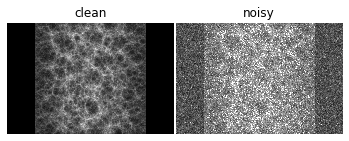

In [24]:
# Show results
proj_clean = tifffile.imread(str(out_proj_dir / "output_00000.tif"))
proj_noisy = tifffile.imread(str(out_proj_noisy_dir / "output_00000.tif"))

fig.plot_imgs(
    clean=proj_clean,
    noisy=proj_noisy,
    width=6.0,
)